# Building a convolutional autoencoder for denoising MR images


In [ ]:
# Import Libraries
import os
import tensorflow as tf
import keras
from keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import scipy.io
from random import sample
from skimage.util import random_noise # useful package for adding noise
from sklearn.model_selection import train_test_split # split training and testing dataset
from keras.initializers import orthogonal
from keras.layers import Input, Conv2D, Dropout, BatchNormalization, Conv2DTranspose
from keras.losses import MeanSquaredError
from keras.callbacks import ModelCheckpoint

# Data Loading and Visualization

Dataset:  2000


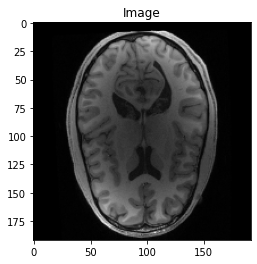

In [43]:
# Import Data; the data is already normalized between [0,1]
def MatLoader(data_dir):
    mat_files   = [f for f in os.listdir(data_dir) if f.endswith('.mat')]
    mat_data    = []
    for f in mat_files:
        mat_path = os.path.join(data_dir, f)  
        mat = scipy.io.loadmat(mat_path) 
        image_data = mat['image']
        mat_data.append(image_data) 
    print("Dataset: ", len(mat_data))
    return mat_data

data_dir    = "/home/shravani/486/TrainingData-20230508T173022Z-001/TrainingData/"
totalData   = MatLoader(data_dir)

# Plot the image
plt.imshow(totalData[100], cmap='gray')
plt.title('Image')
plt.show()

# Adding Noise to Images

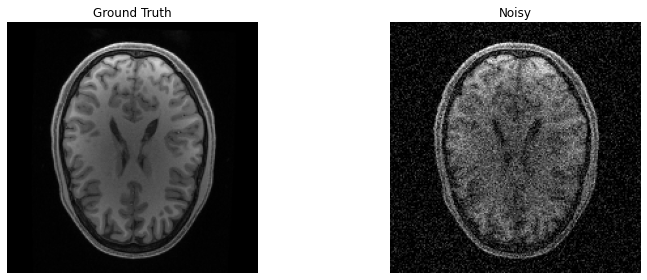

In [55]:
variance = 0.01

noisyData = []
for i in totalData:
    noisy_image = random_noise(i , var = 0.01, mode='gaussian')
    noisyData.append(noisy_image)
noisyData = np.clip(noisyData, 0, 1)  # Clip the noisyData within [0, 1]

indices = np.random.choice(len(totalData), 1, replace=False)
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
for i, index in enumerate(indices):
    gt_image = totalData[index]
    noisy_image = random_noise(gt_image, var=0.01, mode='gaussian', clip=True)
     # Noiseless ground truth image
    axs[0].imshow(gt_image, cmap='gray')
    axs[0].axis('off')
    axs[0].set_title('Ground Truth')

    # Noisy image
    axs[1].imshow(noisy_image, cmap='gray')
    axs[1].axis('off')
    axs[1].set_title('Noisy')

plt.tight_layout()
plt.show()


# Split into training and testing sets

In [27]:
totalData = np.expand_dims(totalData, axis=-1)
noisyData= np.expand_dims(noisyData, axis=-1)

X_train, X_test, y_train, y_test = train_test_split(noisyData, totalData , test_size=0.2, random_state=42)

# Define the architecture of the autoencoder

In [6]:
# Encoder
inputs = Input(shape=(192, 192, 1))
x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

# Decoder
x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
outputs = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

# Create the autoencoder model
autoencoder = Model(inputs=inputs, outputs=outputs)

# Summary of the autoencoder model
autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 192, 192, 64)      640       
                                                                 
 dropout (Dropout)           (None, 192, 192, 64)      0         
                                                                 
 batch_normalization (BatchN  (None, 192, 192, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 192, 128)     73856     
                                                                 
 dropout_1 (Dropout)         (None, 192, 192, 128)     0         
                                                             

2024-02-22 21:25:18.783411: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13874 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0004:04:00.0, compute capability: 7.0
2024-02-22 21:25:18.789427: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13874 MB memory:  -> device: 1, name: Tesla V100-SXM2-16GB, pci bus id: 0004:05:00.0, compute capability: 7.0
2024-02-22 21:25:18.789897: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 13874 MB memory:  -> device: 2, name: Tesla V100-SXM2-16GB, pci bus id: 0035:03:00.0, compute capability: 7.0
2024-02-22 21:25:18.790405: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 13874 MB memory:  -> device: 3, name: Tesla V100-SXM2-16GB, pci bus id

# Compiling and Training the Model

In [7]:
# Compile the model
autoencoder.compile(optimizer=Adam(), loss=MeanSquaredError(), metrics=['mse'])

# Define the path to save the weights
weights_path = '/home/shravani/486/weights.h5'

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(weights_path, monitor='val_loss', save_best_only=True)

# Train the autoencoder with the ModelCheckpoint callback
history = autoencoder.fit(X_train, y_train, batch_size=16, epochs=30, validation_data=(X_test, y_test), callbacks=[checkpoint])

# Load the saved weights from a file
autoencoder.load_weights(weights_path)


Epoch 1/30


2024-02-22 21:27:28.439976: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


100/100 [==============================] - 22s 158ms/step - loss: 0.0209 - mse: 0.0209 - val_loss: 0.0191 - val_mse: 0.0191
Epoch 2/30
100/100 [==============================] - 14s 142ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0304 - val_mse: 0.0304
Epoch 3/30
100/100 [==============================] - 20s 199ms/step - loss: 0.0055 - mse: 0.0055 - val_loss: 0.6185 - val_mse: 0.6185
Epoch 4/30
100/100 [==============================] - 15s 146ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0876 - val_mse: 0.0876
Epoch 5/30
100/100 [==============================] - 15s 152ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 6/30
100/100 [==============================] - 15s 152ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 7/30
100/100 [==============================] - 15s 151ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 8/30
100/100 [==============================] - 15s 150ms/st

# Evaluating the Model

In [8]:
# Evaluate the model on the test set
mse = autoencoder.evaluate(X_test, y_test)
psnr = 20 * np.log10(1.0 / np.sqrt(mse))
print("PSNR:", psnr)

13/13 [==============================] - 3s 69ms/step - loss: 8.5108e-04 - mse: 8.5108e-04
PSNR: [30.70029112 30.70029142]


# Visualizing Denoising Result

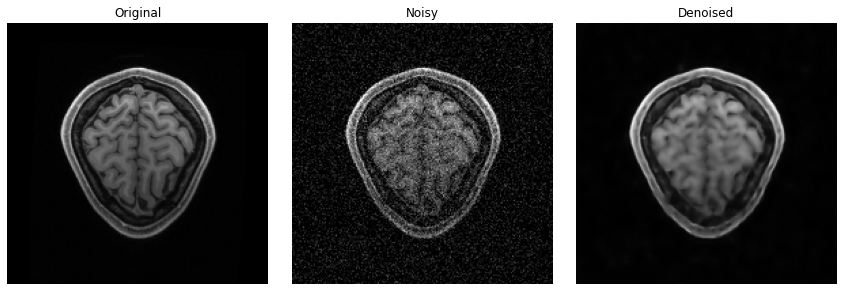

In [41]:
# Visualize results
random_images = np.random.choice(len(X_test), size=1, replace=False)

for idx in random_images:
    original = totalData[idx]
    noisy = noisyData[idx]
    denoised = autoencoder.predict(np.expand_dims(noisy, axis=0))[0]

    # Plot the images
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(original.squeeze(), cmap='gray')
    axs[0].set_title('Original')
    axs[0].axis('off')
    axs[1].imshow(noisy.squeeze(), cmap='gray')
    axs[1].set_title('Noisy')
    axs[1].axis('off')
    axs[2].imshow(denoised.squeeze(), cmap='gray')
    axs[2].set_title('Denoised')
    axs[2].axis('off')

plt.tight_layout()
plt.show()
